# Machine Learning the Atom

This is to explore how one can deploy and optimize a neural network to minimize the energy of a physical system, particularly the hydrogen atom. We are going to begin with simpler examples first.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as colmaps
import pandas as pd
#from sklearn.model_selection import train_test_split

## Problem setup

First we will describe the problem. Let's start in 1D by solving a simple ODE.

## ODE solver

In [2]:
# Model class
class ODESolver(nn.Module):
    """
     A simple deep neural network that fits an ODE solution
    """
    def __init__(self, inp = 2, width = 10):
        
        super(ODESolver, self).__init__() 
        self.myNet = nn.Sequential(
            nn.Linear(inp, width), #Entry point, 1D function
            nn.Tanh(),       #Activation function
            nn.Linear(width,width),
            nn.Tanh(),
            nn.Linear(width, 1) # Output layer
        )
    
    # forwards propagate in the network
    def forward(self, x):
        return self.myNet(x) 

In [11]:
# Custom loss function for unsupervised learning
def lossFunctionODE(model : nn.Module, x : torch.Tensor):

    x.requires_grad = True
    prediction = model(x)

    # calculate grad
    dudx = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
    # True because higher order derivatives are going to be needed in backpropagation

    # These losses define the ODE problem
    domain_loss = (1.0/len(x)) * torch.linalg.vector_norm(dudx + prediction) # need to be weighted bu the number of points
    boundary_loss = (model(torch.tensor([[0.0]])) - 1) ** 2 #initial condition, only one point
    
    return domain_loss + boundary_loss
    

In [12]:
model = ODESolver(inp = 1, width = 5)  # Initialize the model
#optimizer = torch.optim.LBFGS(model.parameters())  # LBFGS optimizer with lr = 1, needs special 'step' treatment
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
x_train = torch.linspace(0, 2, 200).view(-1,1) # reshapes the 1D tensor to a (N,1), -1: automatic length, 1: width of 1
errors = []
epochs = 30000
freq = 100 # for updating console
for epoch in range(epochs+1):
    optimizer.zero_grad()  # Reset gradients
    loss = lossFunctionODE(model, x_train)  # Compute loss
    errors.append(loss.item())
    
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters
    
    if epoch % freq == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}",end="\r")

Epoch 30000, Loss: 3.483496038825251e-055

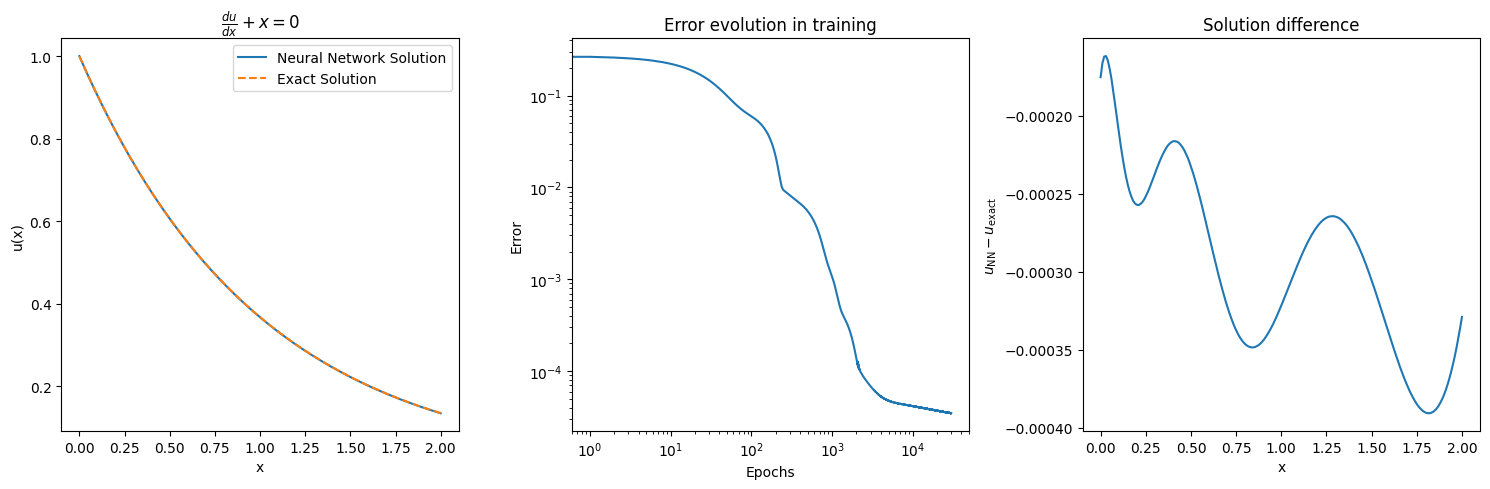

In [13]:
pred = model(x_train).detach().numpy()
np_x = x_train.detach().numpy()
exact = np.exp(-np_x)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
ax1.plot(np_x, pred, label="Neural Network Solution")
ax1.plot(np_x, exact, label="Exact Solution", linestyle="dashed")
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("u(x)")
ax1.set_title(r'$\frac{du}{dx} + x = 0$')

ax2.loglog(np.array(errors))
ax2.set_title("Error evolution in training")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Error")

ax3.plot(np_x, pred-exact, label="Neural Network Solution")
ax3.set_title("Solution difference")
ax3.set_xlabel("x")
ax3.set_ylabel(r'$u_\text{NN}-u_\text{exact}$')

plt.tight_layout()
plt.show()

## PDE solver

In [2]:
def scale_evolution(epochs : int, scales : list, equil_time : int):
    """
    Used to provide incremental scaling to the boundary values 
    through the epochs, to be able to approach the full solution in stages.
    Not currently needed
    """
    
    test = (len(scales)+1) * equil_time
    assert test <= epochs, f"Need more epochs for this equilibration time.  Minimum is {test}"

    s = np.zeros(equil_time)
    for scale in scales:
        s = np.concatenate((s, scale*np.ones(equil_time)))

    return np.concatenate((s, np.ones(epochs + 1 - len(s)) ))
    

In [3]:
# Model class
class LaplaceSolver(nn.Module):
    """
     A simple deep neural network that fits a PDE solution

     Fixed to 3 layers of equal width
     
    """
    def __init__(self, inp = 2, width = 10):
        # super of what? Of this class, call the constructor of the parent class of ODESolver -> nn.Module
        super(LaplaceSolver, self).__init__() 
        self.myNet = nn.Sequential(
            nn.Linear(inp, width), #Entry point
            nn.Tanh(),       #Activation function
            nn.Linear(width,width),
            nn.Tanh(),
            nn.Linear(width, 1) # Output layer
        )
        # initialize the weights with random values and biases with zero
        for layer in self.myNet:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    
    # forwards propagate in the network
    def forward(self, x):
        return self.myNet(x) 

In [4]:
# Custom loss function for unsupervised learning
def lossFunctionPDE(model : nn.Module, x : torch.Tensor, b_points : int = 10, lamb : float = 0.5, scale : float = 1):
    
    # ensure input is (x,y) pairs
    assert len(x[0]) == 2 

    # boundary point selection
    xs = torch.linspace(0, 1, b_points)
    ys = torch.linspace(0, 1, b_points)
    
    # find the boundary (x, y) points
    b_x0 = torch.cartesian_prod(torch.tensor([0.0]), ys)
    b_x1 = torch.cartesian_prod(torch.tensor([1.0]), ys)
    b_y0 = torch.cartesian_prod(xs, torch.tensor([0.0]))
    b_y1 = torch.cartesian_prod(xs, torch.tensor([1.0]))

    # evaluate model output
    x.requires_grad = True
    prediction = model(x)
    
    # calculate first derivative
    dudx = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]

    # calculate the second derivative of the 1st component of the first derivative. Keep only the 1st component of the result
    dudx2 = torch.autograd.grad(dudx[:, 0], x, torch.ones_like(dudx[:, 0]), create_graph=True)[0][:,0]

    # calculate the second derivative of the 2nd component of the first derivative. Keep only the 2nd component of the result
    dudy2 = torch.autograd.grad(dudx[:, 1], x, torch.ones_like(dudx[:, 1]), create_graph=True)[0][:,1]
        
    # calculate the losses
    domain_loss = torch.linalg.vector_norm(dudx2 + dudy2) 
    b_loss_x0 = torch.linalg.vector_norm(model(b_x0))  #boundary condition x = 0
    b_loss_y0 = torch.linalg.vector_norm(model(b_y0) - scale*torch.sin( np.pi * xs).view(-1,1))  #boundary condition y = 0
    b_loss_x1 = torch.linalg.vector_norm(model(b_x1))  #boundary condition x = 1
    b_loss_y1 = torch.linalg.vector_norm(model(b_y1) - scale*torch.sin(6* np.pi * xs).view(-1,1))  #boundary condition y = 1

    # appropriately weigh the loss contributions with lambda and N
    return (lamb)*(domain_loss)/(1.0 * len(x)) + (1-lamb)*(b_loss_x0 + b_loss_y0 + b_loss_x1 + b_loss_y1)/(4.0 * b_points)
    

In [66]:
model = LaplaceSolver(inp = 2, width = 20)  # Initialize the model
#optimizer = torch.optim.LBFGS(model.parameters())  # LBFGS optimizer with lr = 1, needs special 'step' treatment
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
mesh_length = 30
# x_train = torch.linspace(0, 1, mesh_length)
# y_train = torch.linspace(0, 1, mesh_length)
# xy_train = torch.cartesian_prod(x_train, y_train)
xy_train = torch.rand(1000, 2)  # you may also use random points rather than equidistributed

errors = []
epochs = 10000
freq = 100

# Not currently used
# step_time = 100
# steps = [0.001, 0.02, 0.03, 0.05, 0.1, 0.02, 0.03, 0.5]
# s = scale_evolution(epochs, steps, step_time)
# assert len(s) == epochs + 1


for epoch in range(epochs+1):
    optimizer.zero_grad()  # Reset gradients
    loss = lossFunctionPDE(model, xy_train, 
                           b_points=25,   # number of points on each boundary
                           lamb=(8e-3),   # lamb is loss function balancing. Domain contribution ~ lamb
                           scale=1)  # scale = 1, not currenty used
    errors.append(loss.item())
    loss.backward()  
    optimizer.step()  
    if (epoch % freq == 0) and epoch > 1:
        print(f"Epoch {epoch}, Loss: {loss.item()}",end="\r")


Epoch 10000, Loss: 0.011884352192282677

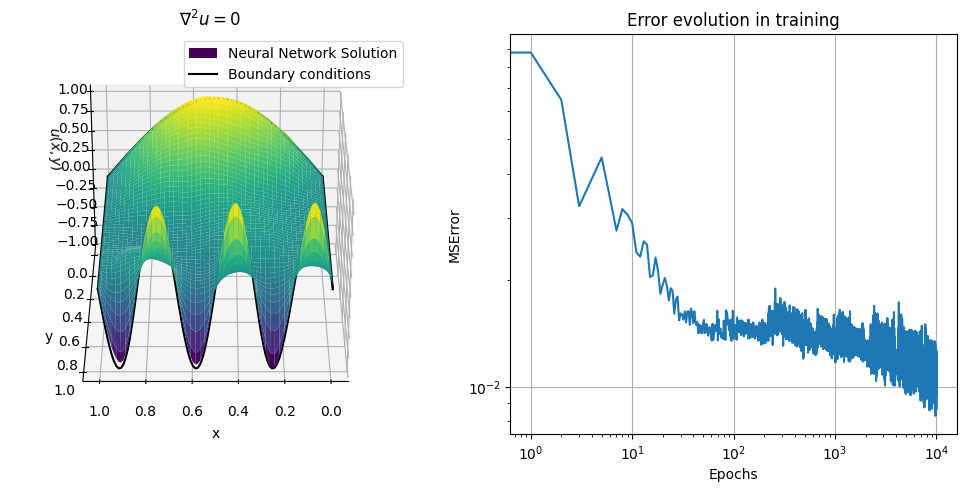

In [67]:
# define testing sizes
bound_reso = 100
bulk_reso = 100

# find test points
x_test = torch.linspace(0, 1, bulk_reso)
y_test = torch.linspace(0, 1, bulk_reso)
xy_test = torch.cartesian_prod(x_test, y_test)

# create the mesh to be plotted
np_x = x_test.detach().numpy()
np_y = y_test.detach().numpy()
np_x, np_y = np.meshgrid(np_x, np_y, indexing='ij') 
# indexing ij is for matrix or xy for cartesian. 
# ij matches input to output dimensions
# xy flips the xy dimensions


# reshape model predictions to match the mesh
pred = model(xy_test).detach().numpy().reshape(bulk_reso,bulk_reso)

# prepare to plot boundaries
zeros_b = np.zeros(bound_reso)
ones_b = np.ones(bound_reso)
range_b = np.linspace(0, 1, bound_reso)
u_b = np.sin(np.pi * range_b)
u_b2 = np.sin(6* np.pi * range_b)


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(np_x, np_y, pred, label="Neural Network Solution", cmap = colmaps.viridis, antialiased=True)
ax1.plot(zeros_b, range_b, zeros_b, color='black', label= 'Boundary conditions')
ax1.plot(range_b, zeros_b, u_b, color='black')
ax1.plot(ones_b, range_b, zeros_b, color='black')
ax1.plot(range_b, ones_b, u_b2, color='black')

ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel(r"$u(x,y)$")
ax1.set_title(r'$\nabla^2{u} = 0$')
ax1.view_init(30, 90)  # rotate viewing angle

ax2 = fig.add_subplot(1, 2, 2)
ax2.loglog(np.array(errors))
ax2.set_title("Error evolution in training")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("MSError")

# to be used with semilogy and the step-wise approach
# ax2.set_xticks(np.arange(0,epochs+1, step_time))
# ax2.set_xticklabels(np.arange(0,epochs+1, step_time), rotation=30)
ax2.grid()

plt.tight_layout()
# plt.savefig('laplace.png') # for publication
plt.show()



Save the model parameters

In [12]:
# torch.save(model.state_dict(), 'model_other.pth')

Load model parameters

In [28]:
# model = LaplaceSolver(inp = 2, width = 20)
# model.load_state_dict(torch.load('model_70k.pth', weights_only=True))

<All keys matched successfully>

## Examples

Epoch 0, Loss: 0.41873326897621155
Epoch 500, Loss: 0.0032194959931075573
Epoch 1000, Loss: 0.001242576283402741
Epoch 1500, Loss: 0.004818866960704327
Epoch 2000, Loss: 0.0007127179414965212
Epoch 2500, Loss: 0.0017601742874830961
Epoch 3000, Loss: 0.0006432356312870979


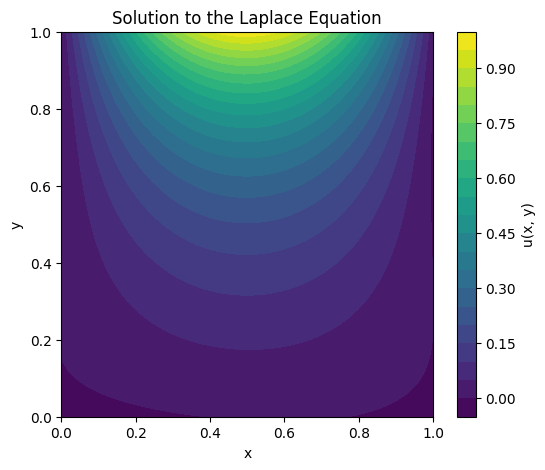

In [81]:
# Define the neural network
class LapSolver(nn.Module):
    def __init__(self):
        super(LapSolver, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),  # Input (x, y)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)   # Output u(x, y)
        )

    def forward(self, xy):
        return self.net(xy)

# Define the PDE loss function
def loss_function(model, xy_train):
    xy_train.requires_grad = True  # Enable differentiation for (x, y)
    
    u = model(xy_train)  # Neural network prediction u(x, y)
    
    # Compute gradients using autograd
    grad_u = torch.autograd.grad(u, xy_train, torch.ones_like(u), create_graph=True)[0]
    du_dx = grad_u[:, 0]  # Partial derivative w.r.t x
    du_dy = grad_u[:, 1]  # Partial derivative w.r.t y

    # Compute second derivatives
    d2u_dx2 = torch.autograd.grad(du_dx, xy_train, torch.ones_like(du_dx), create_graph=True)[0][:, 0:1]
    d2u_dy2 = torch.autograd.grad(du_dy, xy_train, torch.ones_like(du_dy), create_graph=True)[0][:, 1:2]

    laplace_loss = torch.mean((d2u_dx2 + d2u_dy2) ** 2)  # Enforce Laplace equation

    # Boundary conditions
    x_bc = torch.linspace(0, 1, 20).view(-1, 1)
    y_bc = torch.linspace(0, 1, 20).view(-1, 1)

    # Left boundary: u(0, y) = 0
    x_left = torch.zeros_like(y_bc)
    left_bc = torch.cat([x_left, y_bc], dim=1)
    u_left = model(left_bc)
    bc_left_loss = torch.mean(u_left ** 2)

    # Right boundary: u(1, y) = 0
    x_right = torch.ones_like(y_bc)
    right_bc = torch.cat([x_right, y_bc], dim=1)
    u_right = model(right_bc)
    bc_right_loss = torch.mean(u_right ** 2)

    # Bottom boundary: u(x, 0) = 0
    y_bottom = torch.zeros_like(x_bc)
    bottom_bc = torch.cat([x_bc, y_bottom], dim=1)
    u_bottom = model(bottom_bc)
    bc_bottom_loss = torch.mean(u_bottom ** 2)

    # Top boundary: u(x, 1) = sin(pi * x)
    y_top = torch.ones_like(x_bc)
    top_bc = torch.cat([x_bc, y_top], dim=1)
    u_top = model(top_bc)
    bc_top_loss = torch.mean((u_top - torch.sin(np.pi * x_bc).view(-1,1)) ** 2)

    return laplace_loss + bc_left_loss + bc_right_loss + bc_bottom_loss + bc_top_loss

# Training
model = LapSolver()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
xy_train = torch.rand(1000, 2)  # Sample points in the domain [0,1]x[0,1]
for epoch in range(3500):
    optimizer.zero_grad()
    loss = loss_function(model, xy_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Visualizing the solution
x_test = torch.linspace(0, 1, 50)
y_test = torch.linspace(0, 1, 50)
X, Y = torch.meshgrid(x_test, y_test, indexing="ij")
xy_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

u_pred = model(xy_test).detach().numpy().reshape(50, 50)

plt.figure(figsize=(6, 5))
plt.contourf(X.numpy(), Y.numpy(), u_pred, levels=20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution to the Laplace Equation")
plt.show()


## Examples

Plot first and second derivatives, with mixed terms included

In [ ]:
x = torch.tensor([2.0], requires_grad = True)
y = torch.tensor([3.0], requires_grad = True)
xs = torch.cartesian_prod(x,y)

def testf(xs):
    return xs[0,0]**4 * xs[0,1]**4

value = testf(xs)
#print(torch.autograd.grad(value, xs, create_graph=True, allow_unused=True))

# Calculate first-order derivatives with respect to the inputs
first_order_derivatives = torch.autograd.grad(value, xs, grad_outputs=torch.ones_like(value), create_graph=True)[0]

# My way of calculating
verify = []
verify.append(torch.autograd.grad(first_order_derivatives[:, 0], xs, grad_outputs=torch.ones_like(first_order_derivatives[:, 0]), create_graph=True)[0])
verify.append(torch.autograd.grad(first_order_derivatives[:, 1], xs, grad_outputs=torch.ones_like(first_order_derivatives[:, 1]), create_graph=True)[0])

# Calculate second-order derivatives (including mixed derivatives)
second_order_derivatives = torch.zeros((xs.size(1), xs.size(1)))
for i in range(xs.size(1)):
    grad2 = torch.autograd.grad(first_order_derivatives[:, i], xs, torch.ones_like(first_order_derivatives[:, i]), retain_graph=True)[0]
    second_order_derivatives[i, :]  = grad2

print(first_order_derivatives)
print(verify)
print(second_order_derivatives)


In [ ]:
first_order_derivatives[0, 0]

In [ ]:
xs[0,1]